## GW analysis with DM effects (Similar masses)

In this update we will explore the difference in the number of cycles that depends on the mass ratio / total mass with a given local dark matter density. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
from scipy.integrate import solve_ivp, quad

In [2]:
# Define some useful constants and relations
G = const.G
c = const.c

#conversion factors
m2pc = u.pc / const.pc
solar2kg = const.M_sun / u.M_sun
s2hr = u.hour / u.s / (60.0 * 60.0) 
yr2s = 3.154e+7 * u.s

## Useful functions from last notebook

In [3]:
#calculate rsp given Mbh in solar masses, rho_sp in solar masses/pc^3 and spike coefficient gamma
#returns spike radius in pc
def rsp(M, rho, gamma):
    return 1.08e-1 * (  (3-gamma)**(1/3) * (0.2)**(-gamma/3) ) * (M/const.M_sun)**(1/3) * (rho /(u.M_sun / u.pc**3) ) **(-1/3) * u.pc


#calculate halo density given r in pc, rhosp in solar masses/pc^3 and m1 in solar masses
#returns density in solar mass / pc^3
def rho(r, rhosp, gamma, m1):
    return rhosp * ( r / rsp(m1,rhosp,gamma)) **(-gamma)

#Function to calculate the radial decay due to GW and DM energy loss
#time is given in seconds (although no astropy units are explicilty used as the 
#numerical solver isn't compatible with those objects)

def dadt(t, a0, m1, m2, M1, R, rho_const ):
    
    #computing the total and reduced mass
    m = m1 + m2
    mu = m1*m2 / (m)
    
    a = a0*u.m
    l_log = np.log(3)   #coulomb log ~3 according to https://arxiv.org/pdf/1408.3534.pdf
    
    phi = np.sqrt( G * m / a**3  )  #orbital phase
    v  = np.sqrt( G * m  / a )      #from virial theorem K = -1/2 U -> 1/2 m_reduced v^2 = G mtotal * m_reduced / 2a 
    
    #Galactic centre info
    # Galactic centre variables
    #M1 = 1e5 * const.M_sun  #mass of galactic centre
    #R =  6 * G * M1 / c**2 * 1e2  
    #rho_const = rho(R * m2pc , rhosp, gamma, M1)
    
    return -2.0 * a**2 / (G * m * mu) * (  32/5 * G**4 * mu**2 * m**3 / (c**5 * a**5) 
                                     + 4*np.pi*G**2 * mu**2 * rho_const * l_log / v * solar2kg *m2pc**3 ) *u.s / u.m

def dadt_nodm(t, a0,  m1, m2):
    
    #computing the total and reduced mass
    m = m1 + m2
    mu = m1*m2 / (m)
    
    a = a0*u.m
    
    phi = np.sqrt( G * m / a**3  )  #orbital phase
    v  = np.sqrt( G * m  / a )      #from virial theorem K = -1/2 U -> 1/2 m v^2 = G m / 2a 
    
    
    return -2*a**2 / (G * m * mu) * (  32/5 * G**4 * mu**2 * m**3 / (c**5 * a**5) ) *u.s / u.m

#This returns the overal orbital decay dr/dt in units of m/s (that's why they're removed at the end as 
#to be compatitble with the numerical solver)

#function to terminate the evolution when the binary has a separation of about 1 risco
def terminator(t, a, m1, m2):
    return a - 6*const.G * m1 / const.c**2 /u.m

#function to terminate the evolution when the binary has a separation of about 1 risco (only for the DM case)
def terminator_dm(t, a, m1, m2, M1, R, rho_const ):
    return a - 6*const.G * m1 / const.c**2 /u.m

terminator.terminal = True
terminator_dm.terminal = True

#Functions to that compute f_gw / dot(f)_gw as a function of the given gravitaitonal wave frequency f_gw
#The input (f0) is in Hz without astropy units to avoid conflicts with the numerical solver

#for a system without dark matter
def fgw_nodm(f0, m1, m2):
    
    #computing the total mass
    m = m1 + m2
    
    #computing the orbital frequency
    forb = f0 / 2 / u.s
    #computing semimajor axis from the orbital frequency
    a = ( const.G * m / (forb)**2) **(1/3)  
    #computing the decay in semimajor axis
    da = dadt_nodm(0, a / u.m, m1, m2 )
    
    #computing fdot
    fdot = -3 * (G * m) **(-1/3) * (forb)**(5/3) * (da * u.m / u.s) 
    #removing the units for fdot
    fdot = fdot * (u.s)**2
    #computing f_gw / dot(f)_gw
    f_fdot = f0 / fdot
    
    return f_fdot

#for a system with dark matter
def fgw_dm(f0, m1, m2, M1, R, rho_const ):
    
    #computing the total mass
    m = m1 + m2
    
    #computing the orbital frequency
    forb = f0 / 2 / u.s
    #computing semimajor axis from the orbital frequency
    a = ( const.G * m / (forb)**2) **(1/3)  
    #computing the decay in semimajor axis
    da = dadt(0, a / u.m, m1, m2, M1, R, rho_const  )
    
    #computing fdot
    fdot = -3 * (G * m) **(-1/3) * (forb)**(5/3) * (da * u.m / u.s) 
    #removing the units for fdot
    fdot = fdot * (u.s)**2
    #computing f_gw / dot(f)_gw
    f_fdot = f0 / fdot
    
    return f_fdot

#final frequency
def fend(a, m1, m2):
    return np.sqrt( const.G * (m1+ m2) / a**3)

#function to compute at which approximate radius the evolution becomes visible for a detector sensitivity of f_minimum
#and total mass of the system "m"

def a_start(f_minimum, m):
    forb = 0.5 * f_minimum
    return (G * m / forb**2) ** (1/3)

## Creating a grid of mass ratios / total masses for cases in order to produce the heat map

In [4]:
mq_array = [0.1 , 0.19, 0.28, 0.37, 0.46, 0.55, 0.64, 0.73, 0.82, 0.91, 1.  ]
mq = np.meshgrid(mq_array, mq_array)[1]

mtot_array = [1,10, 20, 30, 40, 50, 60, 70, 80, 90, 100 ]
mtot = np.meshgrid(mtot_array, mtot_array)[0]
mtot

Z = mq* mtot

The cases will be printed below (as in expliclty looking at the mass1 and mass2). Do note that under the definitions of 

## $q = \frac{m_2}{m_1}, \quad m = m_1 + m_2$

We will have 

## $m_2 = \frac{q m}{(1 + q)}, \quad m_1 = m - m_2 $

In [5]:
for i in range(0,11):
    for j in range(0,11):
        m22 =  mtot[0][i] * mq[j][0] / (1 + mq[j][0] )
        m11 =  mtot[0][i] - m22
        print("mtot = " + str(mtot[0][i]) + ", mq = " + str(mq[j][0]) + " m2 = " + str(m22) + " m1 = " + str( m11) )

mtot = 1, mq = 0.1 m2 = 0.09090909090909091 m1 = 0.9090909090909091
mtot = 1, mq = 0.19 m2 = 0.1596638655462185 m1 = 0.8403361344537815
mtot = 1, mq = 0.28 m2 = 0.21875000000000003 m1 = 0.78125
mtot = 1, mq = 0.37 m2 = 0.27007299270072993 m1 = 0.7299270072992701
mtot = 1, mq = 0.46 m2 = 0.31506849315068497 m1 = 0.684931506849315
mtot = 1, mq = 0.55 m2 = 0.3548387096774194 m1 = 0.6451612903225806
mtot = 1, mq = 0.64 m2 = 0.39024390243902435 m1 = 0.6097560975609757
mtot = 1, mq = 0.73 m2 = 0.42196531791907516 m1 = 0.5780346820809248
mtot = 1, mq = 0.82 m2 = 0.45054945054945056 m1 = 0.5494505494505495
mtot = 1, mq = 0.91 m2 = 0.47643979057591623 m1 = 0.5235602094240838
mtot = 1, mq = 1.0 m2 = 0.5 m1 = 0.5
mtot = 10, mq = 0.1 m2 = 0.9090909090909091 m1 = 9.090909090909092
mtot = 10, mq = 0.19 m2 = 1.596638655462185 m1 = 8.403361344537815
mtot = 10, mq = 0.28 m2 = 2.1875 m1 = 7.8125
mtot = 10, mq = 0.37 m2 = 2.7007299270072993 m1 = 7.299270072992701
mtot = 10, mq = 0.46 m2 = 3.1506849315068

## Function for evolving the different cases given the grids for the total masses and mass ratios 

In [6]:
def evolver(n,mtot,mq, Z, gamma, rhosp, M1, R):
    for i in range(0,n):
        for j in range(0,n):
            
            #setting the masses
            m2 =  mtot[0][i] * mq[j][0] / (1 + mq[j][0] ) * const.M_sun
            m1 =  mtot[0][i] * const.M_sun - m2
            

            #print("m1 = " + str(m1_X[0][i]) + ", m2 = " + str(m2_Y[j][0]) )
            
            risco = 6 * G * m1 / c**2
            
            fmin = 20 #minimm frequency at which the signal can be detectable to the detector
            a0 = a_start(fmin / u.s, m1 + m2)
            
            #Halo properties:
            rho_const = rho(R * m2pc , rhosp, gamma, M1)  #the constant value from dark matter energy dissipation rho(R)

            #coalescence time
            tcoal = 5/256 * const.c**5 * a0**4 / ( const.G**3 * (m1+m2) * (m1 * m2)  )
            
            
            #Solving the system for the final frequency

            sol_dm = solve_ivp(dadt, args = (m1, m2, M1, R, rho_const ), t_span = [0, tcoal*2 / u.s], y0 = [a0 / u.m], events=terminator_dm,
                               dense_output=True, method = 'RK45' , atol=1e-6, rtol=1e-5)
            a_dm =  sol_dm.sol(sol_dm.t[-1])[0]
            fmax = fend(a_dm * u.m, m1 ,m2) * u.s  #final frequency in hertz (removing units as numerical integration 
                                                   #requires unitless quantities)

            #manually putting the ligo f_max
            if fmax > 1e3 :
                fmax = 1e3

                
            #Integrating the number of cycles
            N_nodm = quad(fgw_nodm, fmin , fmax, args = (m1, m2) )[0]
            N_dm = quad(fgw_dm, fmin , fmax, args = (m1, m2, M1, R, rho_const ) )[0]
            

            Z[j][i] = (N_nodm - N_dm) * 2 * np.pi

            print('\r' + str(j) + ", Completion : " + str(i+1) + "/" + str(n), end='', flush=True)
            
    return Z

## Giving the system the dark matter conditions and total masses / mass ratio arrays

In [50]:
mq_array = [0.1 , 0.19, 0.28, 0.37, 0.46, 0.55, 0.64, 0.73, 0.82, 0.91, 1.  ]
mq = np.meshgrid(mq_array, mq_array)[1]

mtot_array = [1,10, 20, 30, 40, 50, 60, 70, 80, 90, 100 ]
mtot = np.meshgrid(mtot_array, mtot_array)[0]
mtot

#Array configuration for 1-100 Msolar 

#mass ratio
mq_array = [0.1 , 0.19, 0.28, 0.37, 0.46, 0.55, 0.64, 0.73, 0.82, 0.91, 1.  ]
mq = np.meshgrid(mq_array, mq_array)[1]

#total mass
mtot_array = [1,10, 20, 30, 40, 50, 60, 70, 80, 90, 100 ]
mtot = np.meshgrid(mtot_array, mtot_array)[0]

#array to store number of cycles
Z100 = mtot * mq * 0.0

#length of array
n = 11

#Halo properties:
gamma = 2.65  #spike coefficient (7/4 for Self interacting dark matter and 9/4 for primordial black holes)
rhosp = 226 * u.M_sun / u.pc**3 #initial density in solar mass /pc^3

M1 = 1e5 * const.M_sun  #mass of galactic centre
R =  6 * G * M1 / c**2 * 1e1  #Radial distance from galactic centre



Z100 = evolver(n, mtot, mq, Z100, gamma, rhosp, M1, R)

10, Completion : 11/11

## doing a "zoomed-in" test from 1-10 solar masses

In [51]:
#Array configuration for 1-10 Msolar 

#mass ratio
mq_array = [0.1 , 0.19, 0.28, 0.37, 0.46, 0.55, 0.64, 0.73, 0.82, 0.91, 1.  ]
mq = np.meshgrid(mq_array, mq_array)[1]

#total mass
mtot_array = mq_array
mtot = np.meshgrid(mtot_array, mtot_array)[0] * 10

#array to store number of cycles
Z10 = mtot * mq * 0.0


Z10 = evolver(n, mtot, mq, Z10, gamma, rhosp, M1, R)

10, Completion : 11/11

## Looking at the total-mass / mass ratio plots for the number of cycles

## 1-100 solar masses (for the total mass)

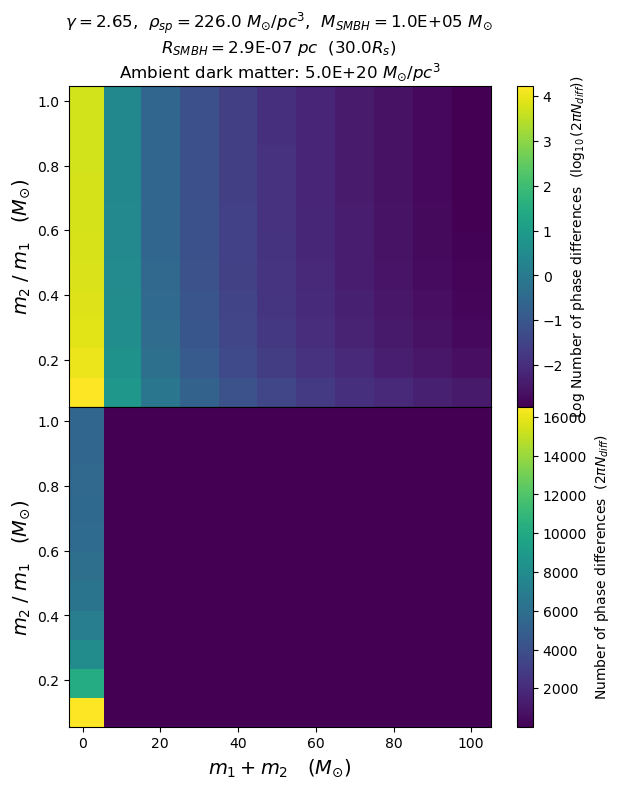

In [52]:
plt.subplots(2, 1, figsize=(6, 7))
plt.tight_layout()

plt.subplot(2, 1, 1)

mtot_array = [1,10, 20, 30, 40, 50, 60, 70, 80, 90, 100 ]
mtot = np.meshgrid(mtot_array, mtot_array)[0]

plt.pcolormesh(mtot,mq, np.log10(Z100) )
plt.ylabel('$m_2 \; / \; m_1 \quad (M_{\odot})$', fontsize=14)
title_gamma = '$\gamma = $' + '{:.2f}'.format(gamma)
title_rho = ',  $\\rho_{sp} = $' + str(rhosp * u.pc**3 / u.M_sun) + " $M_{\odot} / pc^3$"
title_m = ',  $M_{SMBH} = $' + '{:.1E}'.format(M1 / const.M_sun) + ' $M_{\odot}$ \n'
title_r = '$R_{SMBH} = $' + '{:.1E}'.format( R * m2pc / u.pc) + ' $pc$  (' +  '{:.1f}'.format(R / (2 * G * M1 / c**2)) +'$R_s$' +') \n'
title_ambient = 'Ambient dark matter: ' + '{:.1E}'.format(rho(R * m2pc , rhosp, gamma, M1) * u.pc**3 / u.M_sun) + " $M_{\odot} / pc^3$"

plt.title(title_gamma +  title_rho + title_m + title_r + title_ambient )

cb = plt.colorbar()
cb.set_label('Log Number of phase differences  ($\log_{10}{(2 \pi N_{diff} )}$)')


plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0)
plt.pcolormesh(mtot,mq, Z100)
plt.xlabel('$m_1 + m_2 \quad (M_{\odot})$', fontsize=14)
plt.ylabel('$m_2 \; / \; m_1 \quad (M_{\odot})$', fontsize=14)

cb = plt.colorbar()
cb.set_label('Number of phase differences  ($2 \pi N_{diff}$)')

## 1-10 solar masses (for total mass)

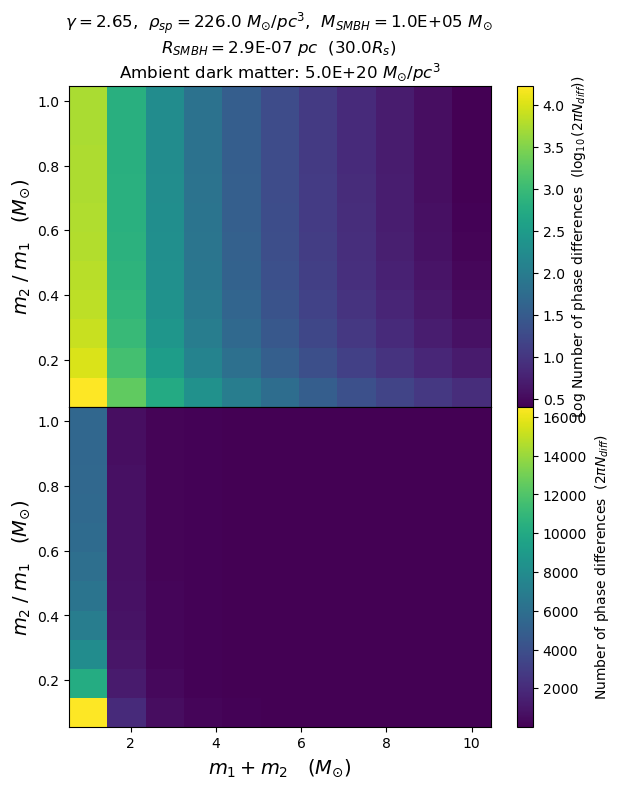

In [53]:
plt.subplots(2, 1, figsize=(6, 7))
plt.tight_layout()

plt.subplot(2, 1, 1)

mtot_array = mq_array
mtot = np.meshgrid(mtot_array, mtot_array)[0] * 10
plt.pcolormesh(mtot,mq, np.log10(Z10) )
plt.ylabel('$m_2 \; / \; m_1 \quad (M_{\odot})$', fontsize=14)
title_gamma = '$\gamma = $' + '{:.2f}'.format(gamma)
title_rho = ',  $\\rho_{sp} = $' + str(rhosp * u.pc**3 / u.M_sun) + " $M_{\odot} / pc^3$"
title_m = ',  $M_{SMBH} = $' + '{:.1E}'.format(M1 / const.M_sun) + ' $M_{\odot}$ \n'
title_r = '$R_{SMBH} = $' + '{:.1E}'.format( R * m2pc / u.pc) + ' $pc$  (' +  '{:.1f}'.format(R / (2 * G * M1 / c**2)) +'$R_s$' +') \n'
title_ambient = 'Ambient dark matter: ' + '{:.1E}'.format(rho(R * m2pc , rhosp, gamma, M1) * u.pc**3 / u.M_sun) + " $M_{\odot} / pc^3$"

plt.title(title_gamma +  title_rho + title_m + title_r + title_ambient )

cb = plt.colorbar()
cb.set_label('Log Number of phase differences  ($\log_{10}{(2 \pi N_{diff} )}$)')


plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0)
plt.pcolormesh(mtot,mq, Z10)
plt.xlabel('$m_1 + m_2 \quad (M_{\odot})$', fontsize=14)
plt.ylabel('$m_2 \; / \; m_1 \quad (M_{\odot})$', fontsize=14)

cb = plt.colorbar()
cb.set_label('Number of phase differences  ($2 \pi N_{diff}$)')

## Why lower mass systems are preferred in this case

Recall

## $ \quad N_{cyc}  = \int_{f_{min}}^{f_{max}} df_{GW} \frac{f_{GW}}{\dot{f}_{GW}}$

Lets focus on the integrand first

## $\quad  \frac{f_{GW}}{\dot{f}_{GW}} = -\frac{f_{GW}}{ 3 (Gm)^{-1/3} (\frac{f_{GW}}{2} )^{5/3} \frac{da}{dt} }$

## $\quad \frac{dr}{dt} = \frac{da}{dt}  = \frac{2a^2}{G m \mu} \Big( 
-\frac{32}{5} \frac{G^4 \mu^2 m^3}{c^5 a^5}
 -\frac{4 \pi G^2 \mu^2 \rho_{DM}(a) \ln{\Lambda}}{v}
 \Big)$

The only thing that differs for the number of cycles between the dark matter / no dark matter case is the dissipative radial term $da/dt$:

## $ \Delta N_{cyc} = N_{no \: DM} - N_{DM} = \int df_{GW} -\frac{1}{3}(\frac{32 Gm}{f^2_{GW}})^{1/3} \big( \frac{1}{\frac{da}{dt}_{noDM}} - \frac{1}{\frac{da}{dt}_{DM}}  \big)$

## $=\int df_{GW} -\frac{1}{3}(\frac{32 Gm}{f^2_{GW}})^{1/3} \big( \frac{
\frac{2a^2}{G m \mu} \Big( 
 -\frac{4 \pi G^2 \mu^2 \rho_{DM}(a) \ln{\Lambda}}{v}
 \Big)
}{\frac{da}{dt}_{noDM} \cdot \frac{da}{dt}_{DM}}   \big)$

## $= \int df_{GW}\frac{1}{3}(\frac{32 Gm}{f^2_{GW}})^{1/3} \big( \frac{ 
 4 \pi G^2 \mu^2 \rho_{DM}(a) \ln{\Lambda}
}{v \cdot 2a^2 ( \frac{32}{5} \frac{G^3 \mu m^2}{c^5 a^5} ) \cdot ( \frac{32}{5} \frac{G^3 \mu m^2}{c^5 a^5} +  \frac{4 \pi G \mu\rho_{DM}(a) \ln{\Lambda}}{ m v} )  } \big), \quad \mu = \frac{m_1 m_2}{m } = m_1^2 \frac{q}{m}  $

By the virial theorem 

## $v = \sqrt{ \frac{Gm }{ a}  } $

In [26]:
f_sample = np.linspace(20,1e3,1000)

m1_sample = 10 * const.M_sun
m2_sample = 10 * const.M_sun
f_integrand = fgw_dm(f_sample, m1_sample, m2_sample, M1, R, rho(R * m2pc , rhosp, gamma, M1) )

m1_sample2 = 20 * const.M_sun
m2_sample2 = 10 * const.M_sun
f_integrand2 = fgw_dm(f_sample, m1_sample2, m2_sample2, M1, R, rho(R * m2pc , rhosp, gamma, M1) )

m1_sample3 = 20 * const.M_sun
m2_sample3 = 20 * const.M_sun
f_integrand3 = fgw_dm(f_sample, m1_sample3, m2_sample3, M1, R, rho(R * m2pc , rhosp, gamma, M1) )

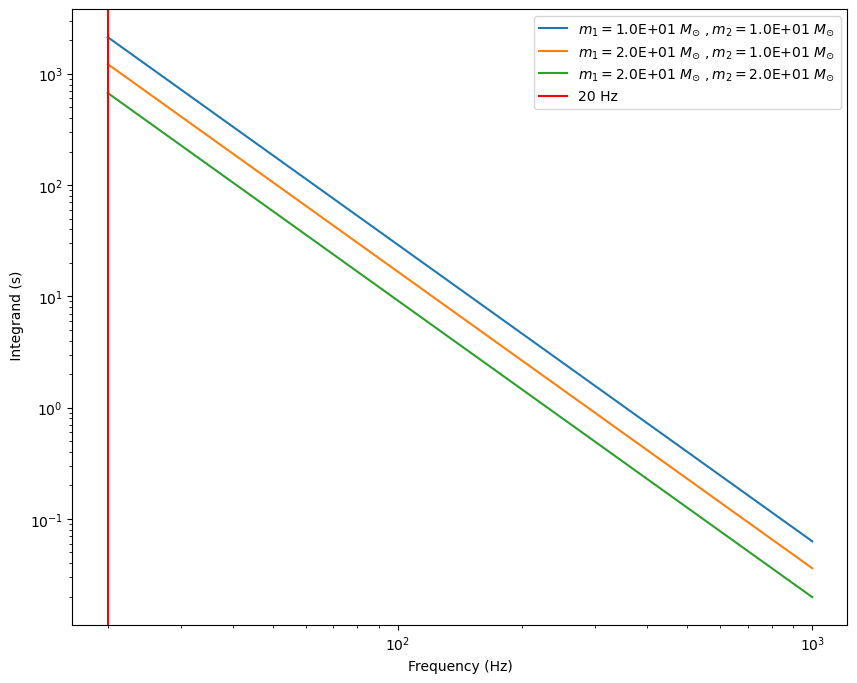

In [27]:
plt.figure(figsize=(10,8));plt.grid()
title_m1 = '$m_{1} = $' + '{:.1E}'.format(m1_sample / const.M_sun) + ' $M_{\odot}$ '
title_m2 = '$, m_{2} = $' + '{:.1E}'.format(m2_sample / const.M_sun) + ' $M_{\odot}$'

plt.plot(f_sample, f_integrand, label = title_m1 + title_m2)

title_m12 = '$m_{1} = $' + '{:.1E}'.format(m1_sample2 / const.M_sun) + ' $M_{\odot}$ '
title_m22 = '$, m_{2} = $' + '{:.1E}'.format(m2_sample2 / const.M_sun) + ' $M_{\odot}$'

plt.plot(f_sample, f_integrand2, label = title_m12 + title_m22)

title_m13 = '$m_{1} = $' + '{:.1E}'.format(m1_sample3 / const.M_sun) + ' $M_{\odot}$ '
title_m23 = '$, m_{2} = $' + '{:.1E}'.format(m2_sample3 / const.M_sun) + ' $M_{\odot}$'

plt.plot(f_sample, f_integrand3, label = title_m13 + title_m23)

plt.xlabel('Frequency (Hz)')
plt.ylabel( ' Integrand (s)')

plt.axvline(x=20, color = 'red', label = '20 Hz')

plt.legend()
plt.grid(); plt.yscale('log');
plt.xscale('log')

## Testing functions (this is just scratch that I used, cleaned up version is summarized above)

In [9]:
top = 100  #top number of stellar masses
step = 10 #spacing between masses



#creation of meshgrids
m1_X, m2_Y = np.meshgrid(range(1,top+1,step),range(1,top+1,step))
Z1 = m1_X * 0.0

n = len(m1_X[0])

#Halo properties:

gamma = 7/3  #spike coefficient (7/4 for Self interacting dark matter and 9/4 for primordial black holes)
rhosp = 226 * u.M_sun / u.pc**3 #initial density in solar mass /pc^3

M1 = 1e5 * const.M_sun  #mass of galactic centre
R =  6 * G * M1 / c**2 * 1e1  #Radial distance from galactic centre

In [10]:
Z1 = evolver(n, m1_X, m2_Y, Z1, gamma, rhosp, M1, R)

9, Completion : 9/9

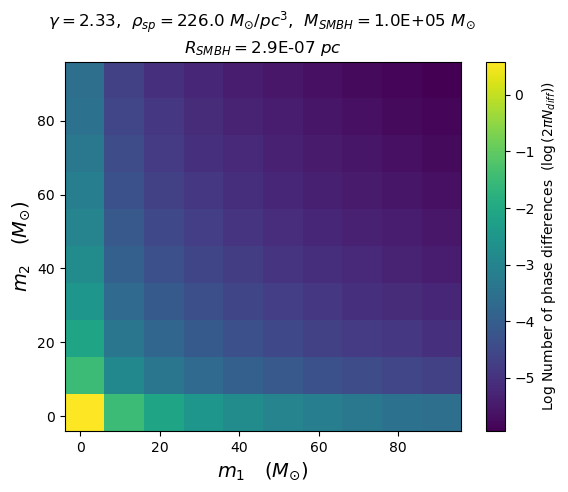

In [11]:
plt.pcolormesh(m1_X,m2_Y, np.log10(Z1))
plt.xlabel('$m_1 \quad (M_{\odot})$', fontsize=14)
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)
title_gamma = '$\gamma = $' + '{:.2f}'.format(gamma)
title_rho = ',  $\\rho_{sp} = $' + str(rhosp * u.pc**3 / u.M_sun) + " $M_{\odot} / pc^3$"
title_m = ',  $M_{SMBH} = $' + '{:.1E}'.format(M1 / const.M_sun) + ' $M_{\odot}$ \n'
title_r = '$R_{SMBH} = $' + '{:.1E}'.format( R * m2pc / u.pc) + ' $pc$' 

plt.title(title_gamma +  title_rho + title_m + title_r )

cb = plt.colorbar()
cb.set_label('Log Number of phase differences  ($\log{(2 \pi N_{diff} )}$)')

In [106]:
top = 10  #top number of stellar masses
step = 1 #spacing between masses



#creation of meshgrids
m1_X, m2_Y = np.meshgrid(range(1,top+1,step),range(1,top+1,step))
Z1 = m1_X * 0.0

n = len(m1_X[0])

#Halo properties:

gamma = 7/3  #spike coefficient (7/4 for Self interacting dark matter and 9/4 for primordial black holes)
rhosp = 226 * u.M_sun / u.pc**3 #initial density in solar mass /pc^3

M1 = 1e5 * const.M_sun  #mass of galactic centre
R =  6 * G * M1 / c**2 * 1e1  #Radial distance from galactic centre

9, Completion : 9/9

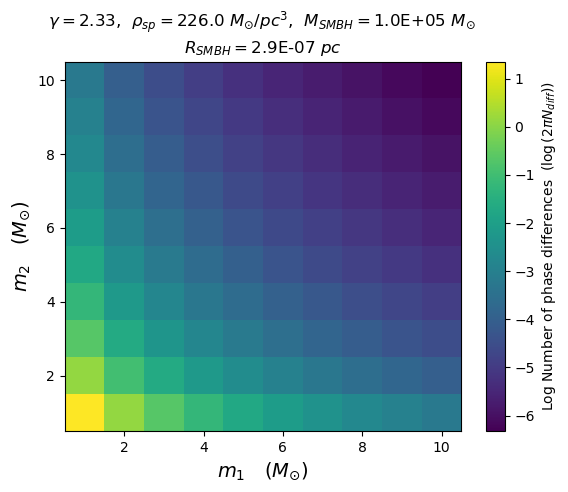

In [107]:
Z1 = evolver(n, m1_X, m2_Y, Z1, gamma, rhosp, M1, R)

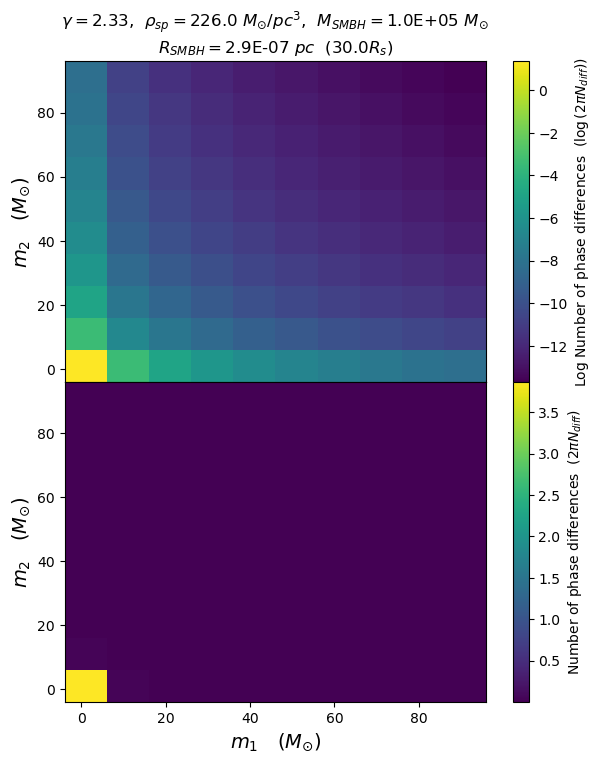

In [12]:
plt.subplots(2, 1, figsize=(6, 7))
plt.tight_layout()

plt.subplot(2, 1, 1)

plt.pcolormesh(m1_X,m2_Y, np.log(Z1))
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)
title_gamma = '$\gamma = $' + '{:.2f}'.format(gamma)
title_rho = ',  $\\rho_{sp} = $' + str(rhosp * u.pc**3 / u.M_sun) + " $M_{\odot} / pc^3$"
title_m = ',  $M_{SMBH} = $' + '{:.1E}'.format(M1 / const.M_sun) + ' $M_{\odot}$ \n'
title_r = '$R_{SMBH} = $' + '{:.1E}'.format( R * m2pc / u.pc) + ' $pc$  (' +  '{:.1f}'.format(R / (2 * G * M1 / c**2)) +'$R_s$' +')'  

plt.title(title_gamma +  title_rho + title_m + title_r )

cb = plt.colorbar()
cb.set_label('Log Number of phase differences  ($\log{(2 \pi N_{diff} )}$)')


plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0)
plt.pcolormesh(m1_X,m2_Y, Z1)
plt.xlabel('$m_1 \quad (M_{\odot})$', fontsize=14)
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)

cb = plt.colorbar()
cb.set_label('Number of phase differences  ($2 \pi N_{diff}$)')

In [10]:
top = 100  #top number of stellar masses
step = 5 #spacing between masses



#creation of meshgrids
m1_X, m2_Y = np.meshgrid(range(1,top+1,step),range(1,top+1,step))
Z1 = m1_X * 0.0

n = len(m1_X[0])

#Halo properties:

gamma = 7/3  #spike coefficient (7/4 for Self interacting dark matter and 9/4 for primordial black holes)
rhosp = 400 * u.M_sun / u.pc**3 #initial density in solar mass /pc^3

M1 = 1e5 * const.M_sun  #mass of galactic centre
R =  60 * G * M1 / c**2  #Radial distance from galactic centre

Z1 = evolver(n, m1_X, m2_Y, Z1, gamma, rhosp, M1, R)

19, Completion : 19/19

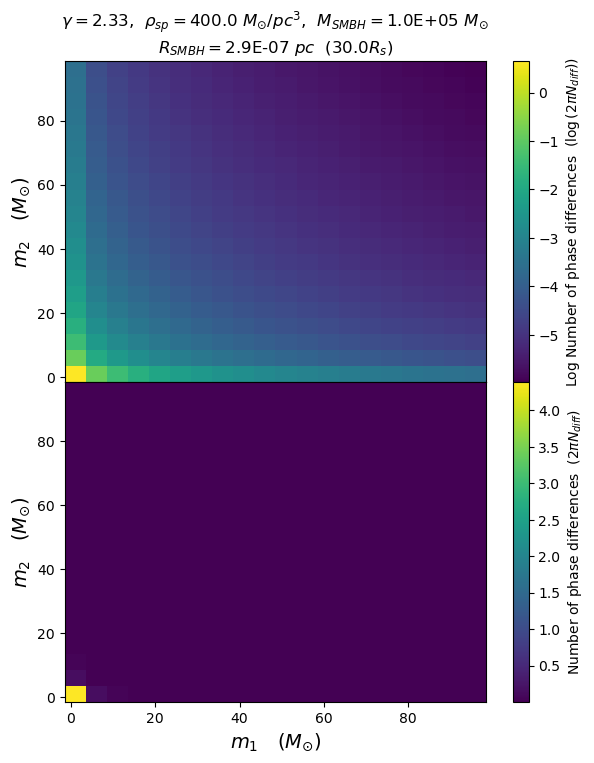

In [11]:
plt.subplots(2, 1, figsize=(6, 7))
plt.tight_layout()

plt.subplot(2, 1, 1)

plt.pcolormesh(m1_X,m2_Y, np.log10(Z1))
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)
title_gamma = '$\gamma = $' + '{:.2f}'.format(gamma)
title_rho = ',  $\\rho_{sp} = $' + str(rhosp * u.pc**3 / u.M_sun) + " $M_{\odot} / pc^3$"
title_m = ',  $M_{SMBH} = $' + '{:.1E}'.format(M1 / const.M_sun) + ' $M_{\odot}$ \n'
title_r = '$R_{SMBH} = $' + '{:.1E}'.format( R * m2pc / u.pc) + ' $pc$  (' +  '{:.1f}'.format(R / (2 * G * M1 / c**2)) +'$R_s$' +')'  

plt.title(title_gamma +  title_rho + title_m + title_r )

cb = plt.colorbar()
cb.set_label('Log Number of phase differences  ($\log{(2 \pi N_{diff} )}$)')


plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0)
plt.pcolormesh(m1_X,m2_Y, Z1)
plt.xlabel('$m_1 \quad (M_{\odot})$', fontsize=14)
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)

cb = plt.colorbar()
cb.set_label('Number of phase differences  ($2 \pi N_{diff}$)')

In [178]:
max(Z1[0])

54.63812554770992

In [42]:
sol2g = const.M_sun * 1e3 / u.kg * u.g / u.M_sun
sol2kg = const.M_sun / u.M_sun
sol2g

<Quantity 1.98840987e+33 g / solMass>

In [33]:
rhosp

<Quantity 226. solMass / pc3>

In [38]:
rhosp * sol2g * (m2pc)**3 * (u.m / u.cm / 100)**3

<Quantity 1.5295466e-20 g / cm3>

In [51]:
kg2ev = 6.242e+18 * (3e8)**2 /u.kg

In [54]:
rhosp * sol2kg * (m2pc)**3 * (u.m / u.cm / 100)**3 *kg2ev /1e9  #GeV

<Quantity 8592.68690664 1 / cm3>

## gamma =2

19, Completion : 19/19

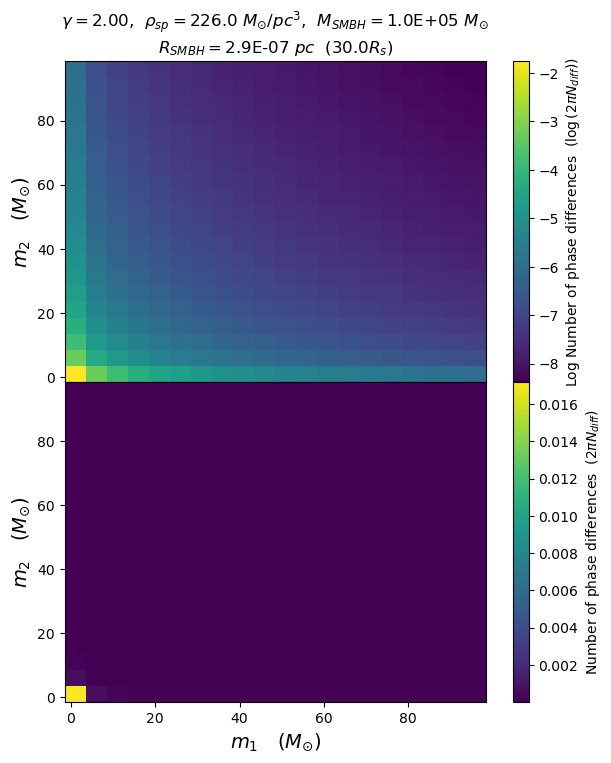

In [12]:
top = 100  #top number of stellar masses
step = 5 #spacing between masses



#creation of meshgrids
m1_X, m2_Y = np.meshgrid(range(1,top+1,step),range(1,top+1,step))
Z1 = m1_X * 0.0

n = len(m1_X[0])

#Halo properties:

gamma = 2  #spike coefficient (7/4 for Self interacting dark matter and 9/4 for primordial black holes)
rhosp = 226 * u.M_sun / u.pc**3 #initial density in solar mass /pc^3

M1 = 1e5 * const.M_sun  #mass of galactic centre
R =  60 * G * M1 / c**2  #Radial distance from galactic centre

Z1 = evolver(n, m1_X, m2_Y, Z1, gamma, rhosp, M1, R)

plt.subplots(2, 1, figsize=(6, 7))
plt.tight_layout()

plt.subplot(2, 1, 1)

plt.pcolormesh(m1_X,m2_Y, np.log10(Z1))
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)
title_gamma = '$\gamma = $' + '{:.2f}'.format(gamma)
title_rho = ',  $\\rho_{sp} = $' + str(rhosp * u.pc**3 / u.M_sun) + " $M_{\odot} / pc^3$"
title_m = ',  $M_{SMBH} = $' + '{:.1E}'.format(M1 / const.M_sun) + ' $M_{\odot}$ \n'
title_r = '$R_{SMBH} = $' + '{:.1E}'.format( R * m2pc / u.pc) + ' $pc$  (' +  '{:.1f}'.format(R / (2 * G * M1 / c**2)) +'$R_s$' +')'  

plt.title(title_gamma +  title_rho + title_m + title_r )

cb = plt.colorbar()
cb.set_label('Log Number of phase differences  ($\log{(2 \pi N_{diff} )}$)')


plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0)
plt.pcolormesh(m1_X,m2_Y, Z1)
plt.xlabel('$m_1 \quad (M_{\odot})$', fontsize=14)
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)

cb = plt.colorbar()
cb.set_label('Number of phase differences  ($2 \pi N_{diff}$)')

## Changing the SMBH's mass

14, Completion : 14/14

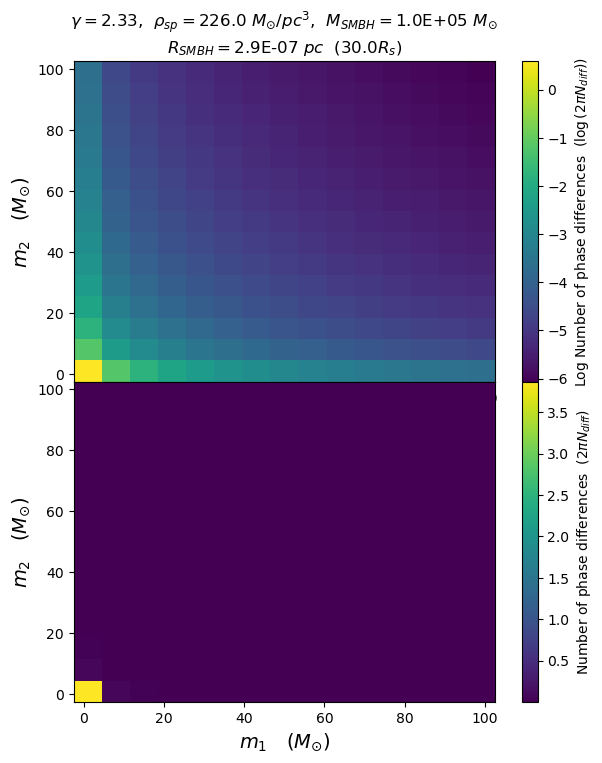

In [13]:
top = 100  #top number of stellar masses
step = 7 #spacing between masses



#creation of meshgrids
m1_X, m2_Y = np.meshgrid(range(1,top+1,step),range(1,top+1,step))
Z1 = m1_X * 0.0

n = len(m1_X[0])

#Halo properties:

gamma = 7/3  #spike coefficient (7/4 for Self interacting dark matter and 9/4 for primordial black holes)
rhosp = 226 * u.M_sun / u.pc**3 #initial density in solar mass /pc^3

M1 = 1e5 * const.M_sun  #mass of galactic centre
R =  60 * G * M1 / c**2  #Radial distance from galactic centre

Z1 = evolver(n, m1_X, m2_Y, Z1, gamma, rhosp, M1, R)

plt.subplots(2, 1, figsize=(6, 7))
plt.tight_layout()

plt.subplot(2, 1, 1)

plt.pcolormesh(m1_X,m2_Y, np.log10(Z1))
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)
title_gamma = '$\gamma = $' + '{:.2f}'.format(gamma)
title_rho = ',  $\\rho_{sp} = $' + str(rhosp * u.pc**3 / u.M_sun) + " $M_{\odot} / pc^3$"
title_m = ',  $M_{SMBH} = $' + '{:.1E}'.format(M1 / const.M_sun) + ' $M_{\odot}$ \n'
title_r = '$R_{SMBH} = $' + '{:.1E}'.format( R * m2pc / u.pc) + ' $pc$  (' +  '{:.1f}'.format(R / (2 * G * M1 / c**2)) +'$R_s$' +')'  

plt.title(title_gamma +  title_rho + title_m + title_r )

cb = plt.colorbar()
cb.set_label('Log Number of phase differences  ($\log{(2 \pi N_{diff} )}$)')


plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0)
plt.pcolormesh(m1_X,m2_Y, Z1)
plt.xlabel('$m_1 \quad (M_{\odot})$', fontsize=14)
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)

cb = plt.colorbar()
cb.set_label('Number of phase differences  ($2 \pi N_{diff}$)')

14, Completion : 14/14

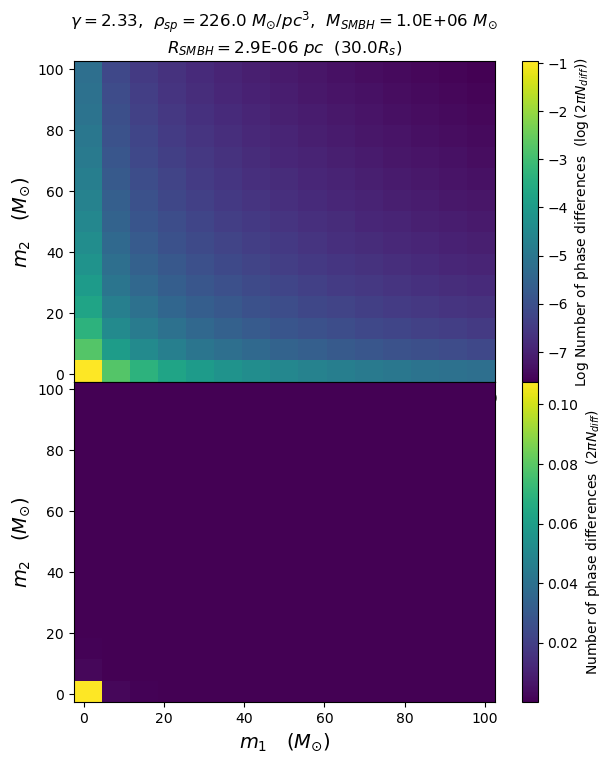

In [14]:
top = 100  #top number of stellar masses
step = 7 #spacing between masses



#creation of meshgrids
m1_X, m2_Y = np.meshgrid(range(1,top+1,step),range(1,top+1,step))
Z1 = m1_X * 0.0

n = len(m1_X[0])

#Halo properties:

gamma = 7/3  #spike coefficient (7/4 for Self interacting dark matter and 9/4 for primordial black holes)
rhosp = 226 * u.M_sun / u.pc**3 #initial density in solar mass /pc^3

M1 = 1e6 * const.M_sun  #mass of galactic centre
R =  60 * G * M1 / c**2  #Radial distance from galactic centre

Z1 = evolver(n, m1_X, m2_Y, Z1, gamma, rhosp, M1, R)

plt.subplots(2, 1, figsize=(6, 7))
plt.tight_layout()

plt.subplot(2, 1, 1)

plt.pcolormesh(m1_X,m2_Y, np.log10(Z1))
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)
title_gamma = '$\gamma = $' + '{:.2f}'.format(gamma)
title_rho = ',  $\\rho_{sp} = $' + str(rhosp * u.pc**3 / u.M_sun) + " $M_{\odot} / pc^3$"
title_m = ',  $M_{SMBH} = $' + '{:.1E}'.format(M1 / const.M_sun) + ' $M_{\odot}$ \n'
title_r = '$R_{SMBH} = $' + '{:.1E}'.format( R * m2pc / u.pc) + ' $pc$  (' +  '{:.1f}'.format(R / (2 * G * M1 / c**2)) +'$R_s$' +')'  

plt.title(title_gamma +  title_rho + title_m + title_r )

cb = plt.colorbar()
cb.set_label('Log Number of phase differences  ($\log{(2 \pi N_{diff} )}$)')


plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0)
plt.pcolormesh(m1_X,m2_Y, Z1)
plt.xlabel('$m_1 \quad (M_{\odot})$', fontsize=14)
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)

cb = plt.colorbar()
cb.set_label('Number of phase differences  ($2 \pi N_{diff}$)')

14, Completion : 14/14

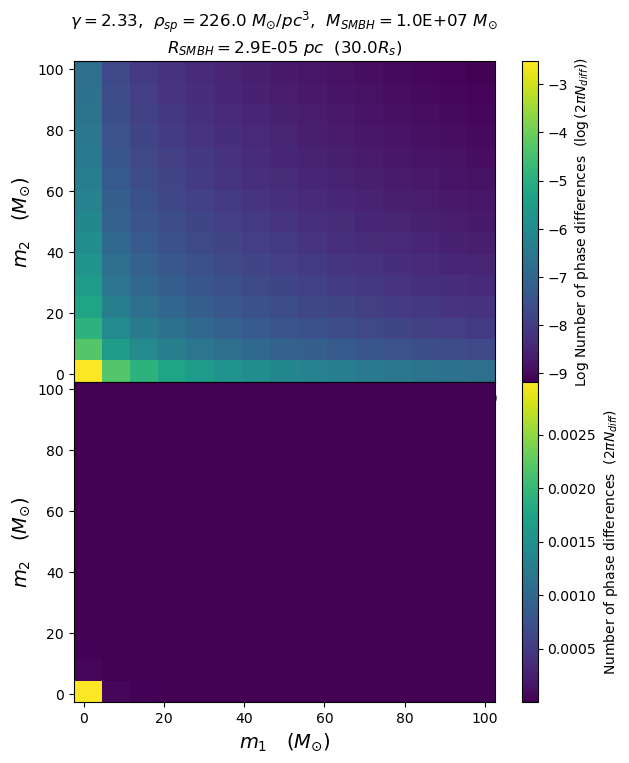

In [15]:
top = 100  #top number of stellar masses
step = 7 #spacing between masses



#creation of meshgrids
m1_X, m2_Y = np.meshgrid(range(1,top+1,step),range(1,top+1,step))
Z1 = m1_X * 0.0

n = len(m1_X[0])

#Halo properties:

gamma = 7/3  #spike coefficient (7/4 for Self interacting dark matter and 9/4 for primordial black holes)
rhosp = 226 * u.M_sun / u.pc**3 #initial density in solar mass /pc^3

M1 = 1e7 * const.M_sun  #mass of galactic centre
R =  60 * G * M1 / c**2  #Radial distance from galactic centre

Z1 = evolver(n, m1_X, m2_Y, Z1, gamma, rhosp, M1, R)

plt.subplots(2, 1, figsize=(6, 7))
plt.tight_layout()

plt.subplot(2, 1, 1)

plt.pcolormesh(m1_X,m2_Y, np.log10(Z1))
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)
title_gamma = '$\gamma = $' + '{:.2f}'.format(gamma)
title_rho = ',  $\\rho_{sp} = $' + str(rhosp * u.pc**3 / u.M_sun) + " $M_{\odot} / pc^3$"
title_m = ',  $M_{SMBH} = $' + '{:.1E}'.format(M1 / const.M_sun) + ' $M_{\odot}$ \n'
title_r = '$R_{SMBH} = $' + '{:.1E}'.format( R * m2pc / u.pc) + ' $pc$  (' +  '{:.1f}'.format(R / (2 * G * M1 / c**2)) +'$R_s$' +')'  

plt.title(title_gamma +  title_rho + title_m + title_r )

cb = plt.colorbar()
cb.set_label('Log Number of phase differences  ($\log{(2 \pi N_{diff} )}$)')


plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0)
plt.pcolormesh(m1_X,m2_Y, Z1)
plt.xlabel('$m_1 \quad (M_{\odot})$', fontsize=14)
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)

cb = plt.colorbar()
cb.set_label('Number of phase differences  ($2 \pi N_{diff}$)')

## Changing the radial distance

14, Completion : 14/14

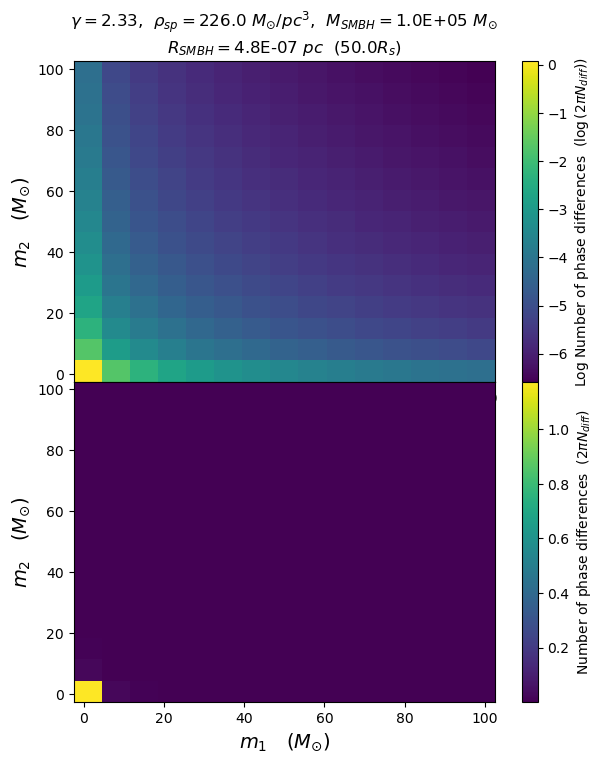

In [16]:
top = 100  #top number of stellar masses
step = 7 #spacing between masses



#creation of meshgrids
m1_X, m2_Y = np.meshgrid(range(1,top+1,step),range(1,top+1,step))
Z1 = m1_X * 0.0

n = len(m1_X[0])

#Halo properties:

gamma = 7/3  #spike coefficient (7/4 for Self interacting dark matter and 9/4 for primordial black holes)
rhosp = 226 * u.M_sun / u.pc**3 #initial density in solar mass /pc^3

M1 = 1e5 * const.M_sun  #mass of galactic centre
R =  100 * G * M1 / c**2  #Radial distance from galactic centre

Z1 = evolver(n, m1_X, m2_Y, Z1, gamma, rhosp, M1, R)

plt.subplots(2, 1, figsize=(6, 7))
plt.tight_layout()

plt.subplot(2, 1, 1)

plt.pcolormesh(m1_X,m2_Y, np.log10(Z1))
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)
title_gamma = '$\gamma = $' + '{:.2f}'.format(gamma)
title_rho = ',  $\\rho_{sp} = $' + str(rhosp * u.pc**3 / u.M_sun) + " $M_{\odot} / pc^3$"
title_m = ',  $M_{SMBH} = $' + '{:.1E}'.format(M1 / const.M_sun) + ' $M_{\odot}$ \n'
title_r = '$R_{SMBH} = $' + '{:.1E}'.format( R * m2pc / u.pc) + ' $pc$  (' +  '{:.1f}'.format(R / (2 * G * M1 / c**2)) +'$R_s$' +')'  

plt.title(title_gamma +  title_rho + title_m + title_r )

cb = plt.colorbar()
cb.set_label('Log Number of phase differences  ($\log{(2 \pi N_{diff} )}$)')


plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0)
plt.pcolormesh(m1_X,m2_Y, Z1)
plt.xlabel('$m_1 \quad (M_{\odot})$', fontsize=14)
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)

cb = plt.colorbar()
cb.set_label('Number of phase differences  ($2 \pi N_{diff}$)')

14, Completion : 14/14

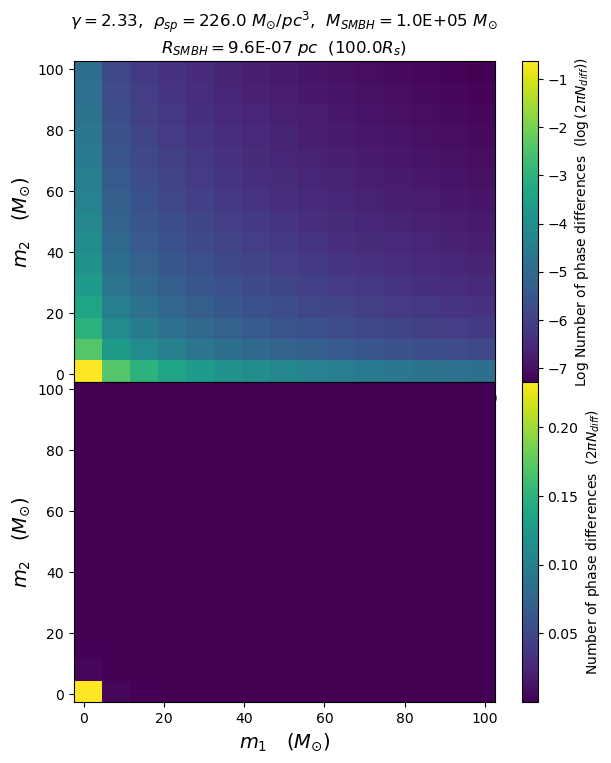

In [17]:
top = 100  #top number of stellar masses
step = 7 #spacing between masses



#creation of meshgrids
m1_X, m2_Y = np.meshgrid(range(1,top+1,step),range(1,top+1,step))
Z1 = m1_X * 0.0

n = len(m1_X[0])

#Halo properties:

gamma = 7/3  #spike coefficient (7/4 for Self interacting dark matter and 9/4 for primordial black holes)
rhosp = 226 * u.M_sun / u.pc**3 #initial density in solar mass /pc^3

M1 = 1e5 * const.M_sun  #mass of galactic centre
R =  200 * G * M1 / c**2  #Radial distance from galactic centre

Z1 = evolver(n, m1_X, m2_Y, Z1, gamma, rhosp, M1, R)

plt.subplots(2, 1, figsize=(6, 7))
plt.tight_layout()

plt.subplot(2, 1, 1)

plt.pcolormesh(m1_X,m2_Y, np.log10(Z1))
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)
title_gamma = '$\gamma = $' + '{:.2f}'.format(gamma)
title_rho = ',  $\\rho_{sp} = $' + str(rhosp * u.pc**3 / u.M_sun) + " $M_{\odot} / pc^3$"
title_m = ',  $M_{SMBH} = $' + '{:.1E}'.format(M1 / const.M_sun) + ' $M_{\odot}$ \n'
title_r = '$R_{SMBH} = $' + '{:.1E}'.format( R * m2pc / u.pc) + ' $pc$  (' +  '{:.1f}'.format(R / (2 * G * M1 / c**2)) +'$R_s$' +')'  

plt.title(title_gamma +  title_rho + title_m + title_r )

cb = plt.colorbar()
cb.set_label('Log Number of phase differences  ($\log{(2 \pi N_{diff} )}$)')


plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0)
plt.pcolormesh(m1_X,m2_Y, Z1)
plt.xlabel('$m_1 \quad (M_{\odot})$', fontsize=14)
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)

cb = plt.colorbar()
cb.set_label('Number of phase differences  ($2 \pi N_{diff}$)')

14, Completion : 14/14

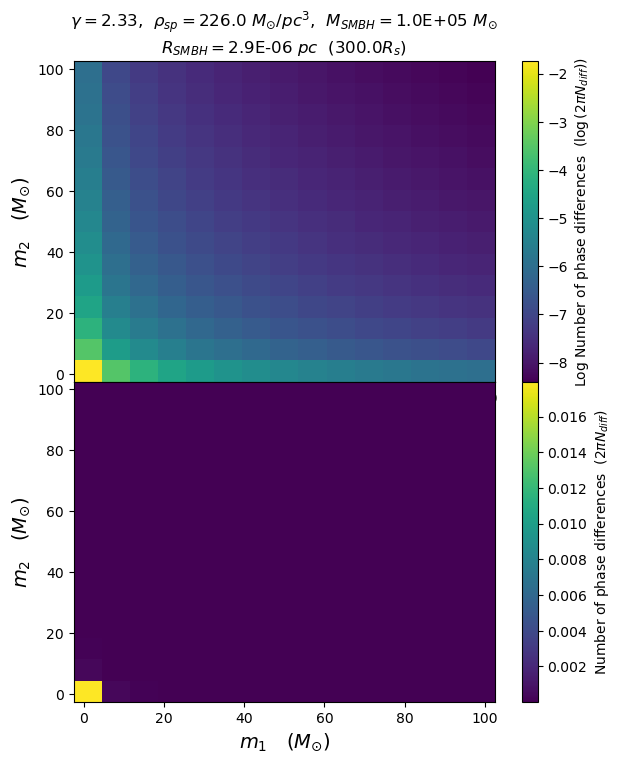

In [18]:
top = 100  #top number of stellar masses
step = 7 #spacing between masses



#creation of meshgrids
m1_X, m2_Y = np.meshgrid(range(1,top+1,step),range(1,top+1,step))
Z1 = m1_X * 0.0

n = len(m1_X[0])

#Halo properties:

gamma = 7/3  #spike coefficient (7/4 for Self interacting dark matter and 9/4 for primordial black holes)
rhosp = 226 * u.M_sun / u.pc**3 #initial density in solar mass /pc^3

M1 = 1e5 * const.M_sun  #mass of galactic centre
R =  600 * G * M1 / c**2  #Radial distance from galactic centre

Z1 = evolver(n, m1_X, m2_Y, Z1, gamma, rhosp, M1, R)

plt.subplots(2, 1, figsize=(6, 7))
plt.tight_layout()

plt.subplot(2, 1, 1)

plt.pcolormesh(m1_X,m2_Y, np.log10(Z1))
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)
title_gamma = '$\gamma = $' + '{:.2f}'.format(gamma)
title_rho = ',  $\\rho_{sp} = $' + str(rhosp * u.pc**3 / u.M_sun) + " $M_{\odot} / pc^3$"
title_m = ',  $M_{SMBH} = $' + '{:.1E}'.format(M1 / const.M_sun) + ' $M_{\odot}$ \n'
title_r = '$R_{SMBH} = $' + '{:.1E}'.format( R * m2pc / u.pc) + ' $pc$  (' +  '{:.1f}'.format(R / (2 * G * M1 / c**2)) +'$R_s$' +')'  

plt.title(title_gamma +  title_rho + title_m + title_r )

cb = plt.colorbar()
cb.set_label('Log Number of phase differences  ($\log{(2 \pi N_{diff} )}$)')


plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0)
plt.pcolormesh(m1_X,m2_Y, Z1)
plt.xlabel('$m_1 \quad (M_{\odot})$', fontsize=14)
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)

cb = plt.colorbar()
cb.set_label('Number of phase differences  ($2 \pi N_{diff}$)')

## Guideline

14, Completion : 14/14

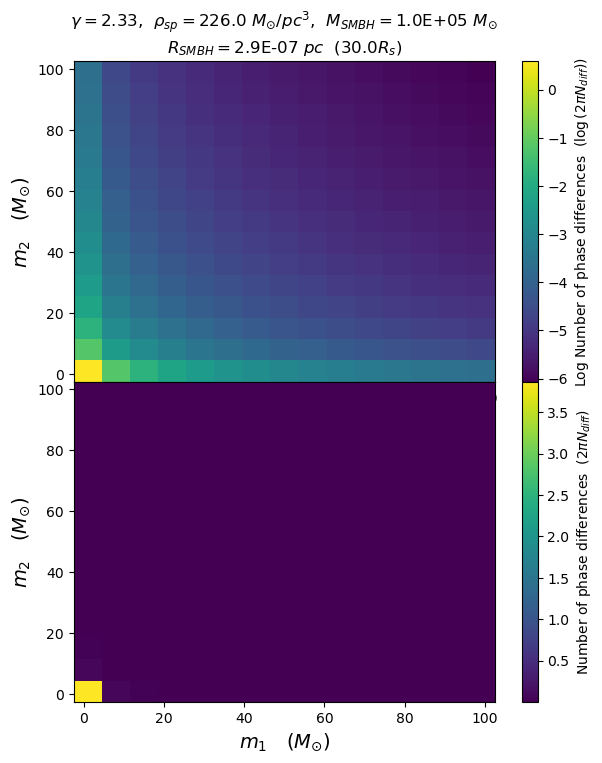

In [19]:
top = 100  #top number of stellar masses
step = 7 #spacing between masses



#creation of meshgrids
m1_X, m2_Y = np.meshgrid(range(1,top+1,step),range(1,top+1,step))
Z1 = m1_X * 0.0

n = len(m1_X[0])

#Halo properties:

gamma = 7/3  #spike coefficient (7/4 for Self interacting dark matter and 9/4 for primordial black holes)
rhosp = 226 * u.M_sun / u.pc**3 #initial density in solar mass /pc^3

M1 = 1e5 * const.M_sun  #mass of galactic centre
R =  60 * G * M1 / c**2  #Radial distance from galactic centre

Z1 = evolver(n, m1_X, m2_Y, Z1, gamma, rhosp, M1, R)

plt.subplots(2, 1, figsize=(6, 7))
plt.tight_layout()

plt.subplot(2, 1, 1)

plt.pcolormesh(m1_X,m2_Y, np.log10(Z1))
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)
title_gamma = '$\gamma = $' + '{:.2f}'.format(gamma)
title_rho = ',  $\\rho_{sp} = $' + str(rhosp * u.pc**3 / u.M_sun) + " $M_{\odot} / pc^3$"
title_m = ',  $M_{SMBH} = $' + '{:.1E}'.format(M1 / const.M_sun) + ' $M_{\odot}$ \n'
title_r = '$R_{SMBH} = $' + '{:.1E}'.format( R * m2pc / u.pc) + ' $pc$  (' +  '{:.1f}'.format(R / (2 * G * M1 / c**2)) +'$R_s$' +')'  

plt.title(title_gamma +  title_rho + title_m + title_r )

cb = plt.colorbar()
cb.set_label('Log Number of phase differences  ($\log{(2 \pi N_{diff} )}$)')


plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0)
plt.pcolormesh(m1_X,m2_Y, Z1)
plt.xlabel('$m_1 \quad (M_{\odot})$', fontsize=14)
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)

cb = plt.colorbar()
cb.set_label('Number of phase differences  ($2 \pi N_{diff}$)')

9, Completion : 9/9

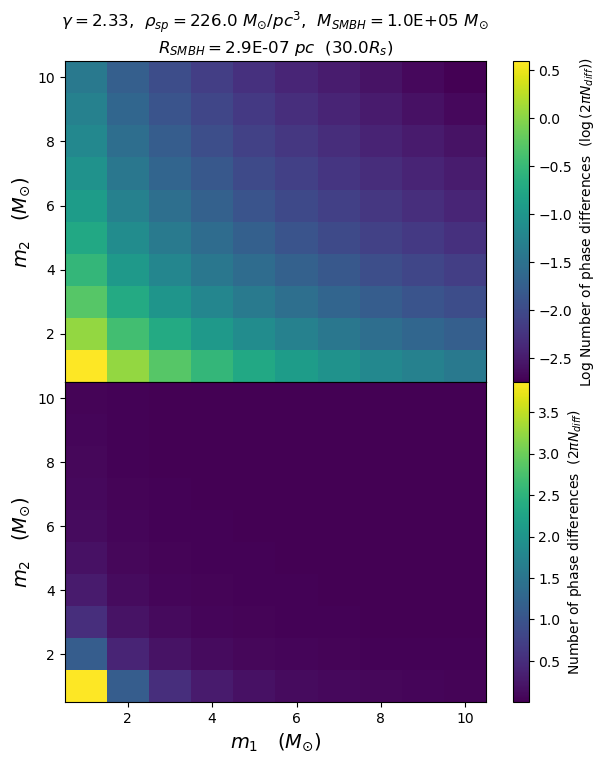

In [20]:
top = 10  #top number of stellar masses
step = 1 #spacing between masses



#creation of meshgrids
m1_X, m2_Y = np.meshgrid(range(1,top+1,step),range(1,top+1,step))
Z1 = m1_X * 0.0

n = len(m1_X[0])

#Halo properties:

gamma = 7/3  #spike coefficient (7/4 for Self interacting dark matter and 9/4 for primordial black holes)
rhosp = 226 * u.M_sun / u.pc**3 #initial density in solar mass /pc^3

M1 = 1e5 * const.M_sun  #mass of galactic centre
R =  60 * G * M1 / c**2  #Radial distance from galactic centre

Z1 = evolver(n, m1_X, m2_Y, Z1, gamma, rhosp, M1, R)

plt.subplots(2, 1, figsize=(6, 7))
plt.tight_layout()

plt.subplot(2, 1, 1)

plt.pcolormesh(m1_X,m2_Y, np.log10(Z1))
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)
title_gamma = '$\gamma = $' + '{:.2f}'.format(gamma)
title_rho = ',  $\\rho_{sp} = $' + str(rhosp * u.pc**3 / u.M_sun) + " $M_{\odot} / pc^3$"
title_m = ',  $M_{SMBH} = $' + '{:.1E}'.format(M1 / const.M_sun) + ' $M_{\odot}$ \n'
title_r = '$R_{SMBH} = $' + '{:.1E}'.format( R * m2pc / u.pc) + ' $pc$  (' +  '{:.1f}'.format(R / (2 * G * M1 / c**2)) +'$R_s$' +')'  

plt.title(title_gamma +  title_rho + title_m + title_r )

cb = plt.colorbar()
cb.set_label('Log Number of phase differences  ($\log{(2 \pi N_{diff} )}$)')


plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0)
plt.pcolormesh(m1_X,m2_Y, Z1)
plt.xlabel('$m_1 \quad (M_{\odot})$', fontsize=14)
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)

cb = plt.colorbar()
cb.set_label('Number of phase differences  ($2 \pi N_{diff}$)')

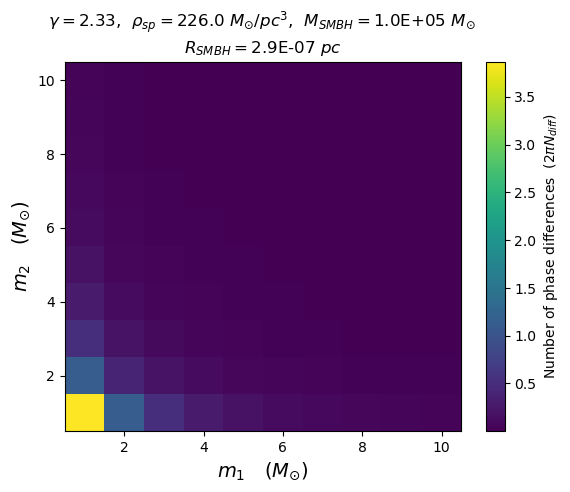

In [108]:
plt.pcolormesh(m1_X,m2_Y, Z1)
plt.xlabel('$m_1 \quad (M_{\odot})$', fontsize=14)
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)
title_gamma = '$\gamma = $' + '{:.2f}'.format(gamma)
title_rho = ',  $\\rho_{sp} = $' + str(rhosp * u.pc**3 / u.M_sun) + " $M_{\odot} / pc^3$"
title_m = ',  $M_{SMBH} = $' + '{:.1E}'.format(M1 / const.M_sun) + ' $M_{\odot}$ \n'
title_r = '$R_{SMBH} = $' + '{:.1E}'.format( R * m2pc / u.pc) + ' $pc$' 

plt.title(title_gamma +  title_rho + title_m + title_r )

cb = plt.colorbar()
cb.set_label('Number of phase differences  ($2 \pi N_{diff}$)')

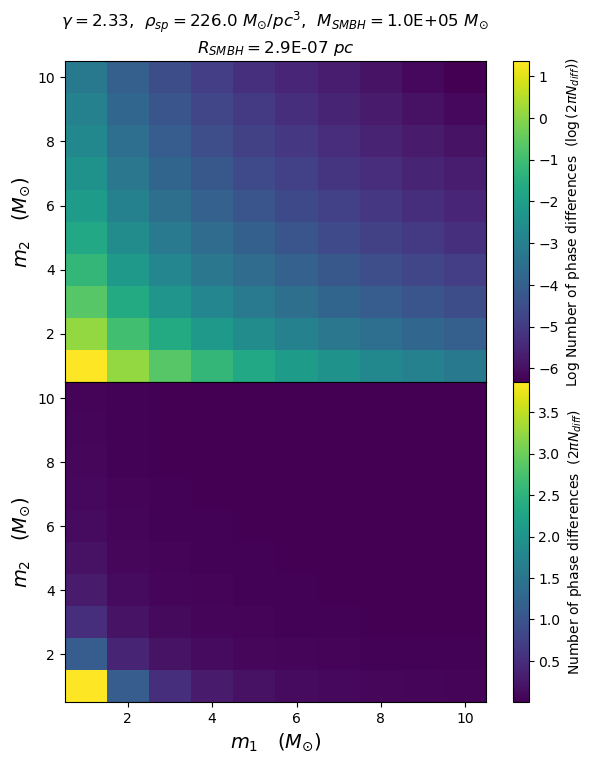

In [137]:
plt.subplots(2, 1, figsize=(6, 7))
plt.tight_layout()

plt.subplot(2, 1, 1)

plt.pcolormesh(m1_X,m2_Y, np.log(Z1))
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)
title_gamma = '$\gamma = $' + '{:.2f}'.format(gamma)
title_rho = ',  $\\rho_{sp} = $' + str(rhosp * u.pc**3 / u.M_sun) + " $M_{\odot} / pc^3$"
title_m = ',  $M_{SMBH} = $' + '{:.1E}'.format(M1 / const.M_sun) + ' $M_{\odot}$ \n'
title_r = '$R_{SMBH} = $' + '{:.1E}'.format( R * m2pc / u.pc) + ' $pc$' 

plt.title(title_gamma +  title_rho + title_m + title_r )

cb = plt.colorbar()
cb.set_label('Log Number of phase differences  ($\log{(2 \pi N_{diff} )}$)')


plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0)
plt.pcolormesh(m1_X,m2_Y, Z1)
plt.xlabel('$m_1 \quad (M_{\odot})$', fontsize=14)
plt.ylabel('$m_2 \quad (M_{\odot})$', fontsize=14)

cb = plt.colorbar()
cb.set_label('Number of phase differences  ($2 \pi N_{diff}$)')

In [159]:
#creating an aray of frequencies and storage for DM/no DM effects
n = 100 #number of elements

gw_freq = np.linspace(fmin, fmax,n)
N_freq_dm = np.linspace(fmin, fmax,n)
N_freq_nodm = np.linspace(fmin, fmax,n)

for i in range(n):
    N_freq_dm[i] = quad(fgw, fmin , gw_freq[i] )[0]
    N_freq_nodm[i] = quad(fgw_nodm, fmin , gw_freq[i] )[0]

Text(0, 0.5, 'Difference in the number of cylces (radians)')

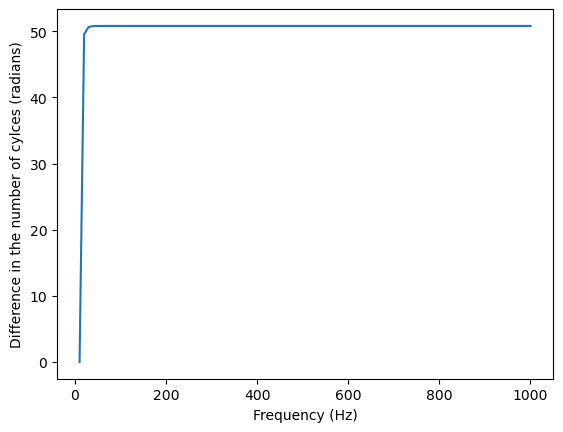

In [160]:
plt.plot(gw_freq , (N_freq_nodm - N_freq_dm )*2*np.pi )
plt.xlabel('Frequency (Hz)')
plt.ylabel('Difference in the number of cylces (radians)')

### Changing it to 100 risco (from the galactic centre)

In [170]:
N_dm = quad(fgw, fmin , fmax )[0]
N_nodm = quad(fgw_nodm, fmin , fmax )[0]

In [171]:
N_diff = N_nodm - N_dm
N_diff

0.037530217319726944

In [172]:
#creating an aray of frequencies and storage for DM/no DM effects
n = 100 #number of elements

gw_freq = np.linspace(fmin, fmax,n)
N_freq_dm = np.linspace(fmin, fmax,n)
N_freq_nodm = np.linspace(fmin, fmax,n)

for i in range(n):
    N_freq_dm[i] = quad(fgw, fmin , gw_freq[i] )[0]
    N_freq_nodm[i] = quad(fgw_nodm, fmin , gw_freq[i] )[0]

Text(0, 0.5, 'Difference in the number of cylces (radians)')

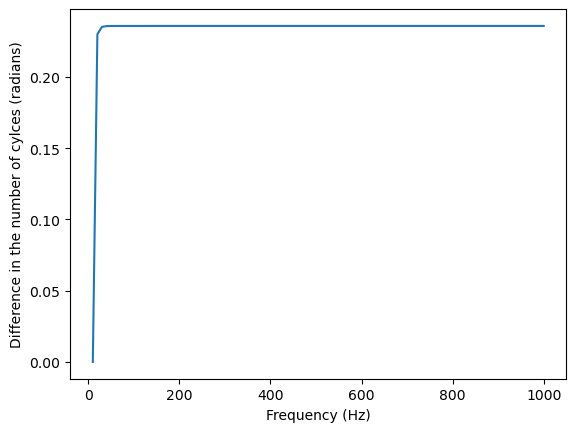

In [173]:
plt.plot(gw_freq , (N_freq_nodm - N_freq_dm )*2*np.pi )
plt.xlabel('Frequency (Hz)')
plt.ylabel('Difference in the number of cylces (radians)')

In [174]:
R

<Quantity 8.85975023e+09 m>

In [175]:
R * m2pc

<Quantity 2.8712495e-07 pc>

In [177]:
6 * G * M1 / c**2 * 1e2 * m2pc

<Quantity 2.8712495e-06 pc>